In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read data
df = pd.read_excel('Online_retail.xlsx', sheet_name='Online Retail')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

CustomerId and Description columns have null records. Because we are planning to predict CLTV, we need records for each customer ID to proceed calculations. Let’s drop rows containing NULL values

In [4]:
df.shape

(541909, 8)

In [5]:
df.dropna(subset=['CustomerID'],inplace=True)

In [6]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Quantity column has negative values, which may be due to returning products after a purchase. Let us drop the rows with a negative quantity
UnitPrice column also has negative records. I decided to drop the records with negative price as well

In [8]:
df = df.loc[df.Quantity >= 0]

In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


Period of time for the purchase records is from December 1, 2010 to December 9, 2011. The data for the last month is incomplete. Because we are planning to predict CLTV for the next 3 months and we will be aggregating data monthly, let us ignore the records for the incomplete month.

After data cleaning, let us calculate total sales:


In [10]:
df['sale_value'] = df['Quantity'] * df['UnitPrice']

In [11]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Create dataframe with orders per customer

In [12]:
df_orders = df.groupby(['CustomerID','InvoiceNo']).agg({'sale_value':sum,'InvoiceDate':max})

In [13]:
df_orders

sale_value         InvoiceDate
CustomerID InvoiceNo                                
12346.0    541431       77183.60 2011-01-18 10:01:00
12347.0    537626         711.79 2010-12-07 14:57:00
           542237         475.39 2011-01-26 14:30:00
           549222         636.25 2011-04-07 10:43:00
           556201         382.52 2011-06-09 13:01:00
...                          ...                 ...
18283.0    579673         223.61 2011-11-30 12:59:00
           580872         208.00 2011-12-06 12:02:00
18287.0    554065         765.28 2011-05-22 10:39:00
           570715        1001.32 2011-10-12 10:23:00
           573167          70.68 2011-10-28 09:29:00

[18536 rows x 2 columns]

To predict and calculate CLTV, we have to estimate the frequency, recency, and total amount of purchases by each customer. We are going to determine basic information about each customer’s average and lifetime purchase amount, as well as each customer’s duration and frequency of purchase.

In [14]:

# Create functions
def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return (x.max() - x.min()).days / x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'
# Create a summary using df_orders
df_summary = df_orders.reset_index().groupby('CustomerID').agg({
            'sale_value': [min, max, sum, groupby_mean, groupby_count],
            'InvoiceDate': [min, max, purchase_duration, avg_frequency]
             })

In [15]:
df_summary

sale_value                                          \
                  min       max       sum           avg count   
CustomerID                                                      
12346.0      77183.60  77183.60  77183.60  77183.600000     1   
12347.0        224.82   1294.32   4310.00    615.714286     7   
12348.0        227.44    892.80   1797.24    449.310000     4   
12349.0       1757.55   1757.55   1757.55   1757.550000     1   
12350.0        334.40    334.40    334.40    334.400000     1   
...               ...       ...       ...           ...   ...   
18280.0        180.60    180.60    180.60    180.600000     1   
18281.0         80.82     80.82     80.82     80.820000     1   
18282.0         77.84    100.21    178.05     89.025000     2   
18283.0          1.95    313.65   2094.88    130.930000    16   
18287.0         70.68   1001.32   1837.28    612.426667     3   

                   InvoiceDate                                        \
                           min                 max purchase_duration   
CustomerID                                                             
12346.0    2011-01-18 10:01:00 2011-01-18 10:01:00                 0   
12347.0    2010-12-07 14:57:00 2011-12-07 15:52:00               365   
12348.0    2010-12-16 19:09:00 2011-09-25 13:13:00               282   
12349.0    2011-11-21 09:51:00 2011-11-21 09:51:00                 0   
12350.0    2011-02-02 16:01:00 2011-02-02 16:01:00                 0   
...                        ...                 ...               ...   
18280.0    2011-03-07 09:52:00 2011-03-07 09:52:00                 0   
18281.0    2011-06-12 10:53:00 2011-06-12 10:53:00                 0   
18282.0    2011-08-05 13:35:00 2011-12-02 11:43:00               118   
18283.0    2011-01-06 14:14:00 2011-12-06 12:02:00               333   
18287.0    2011-05-22 10:39:00 2011-10-28 09:29:00               158   

                               
           purchase_frequency  
CustomerID                     
12346.0              0.000000  
12347.0             52.142857  
12348.0             70.500000  
12349.0              0.000000  
12350.0              0.000000  
...                       ...  
18280.0              0.000000  
18281.0              0.000000  
18282.0             59.000000  
18283.0             20.812500  
18287.0             52.666667  

[4339 rows x 9 columns]

Repeat Customers

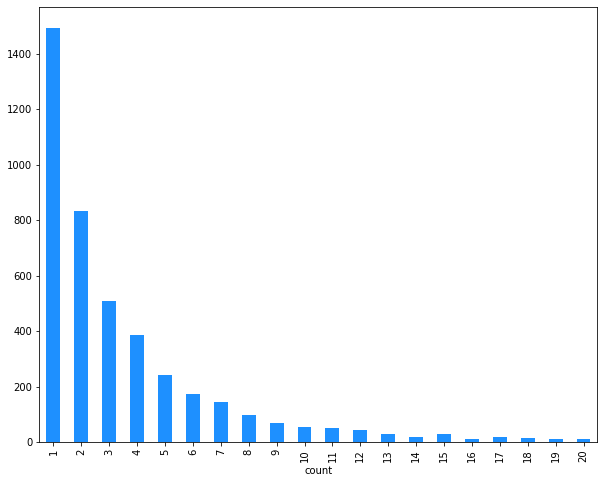

In [16]:
ax = df_summary.sale_value.groupby('count').count()['avg'][:20].plot(kind='bar',color='dodgerblue', 
        figsize=(10,8), 
        grid=False)

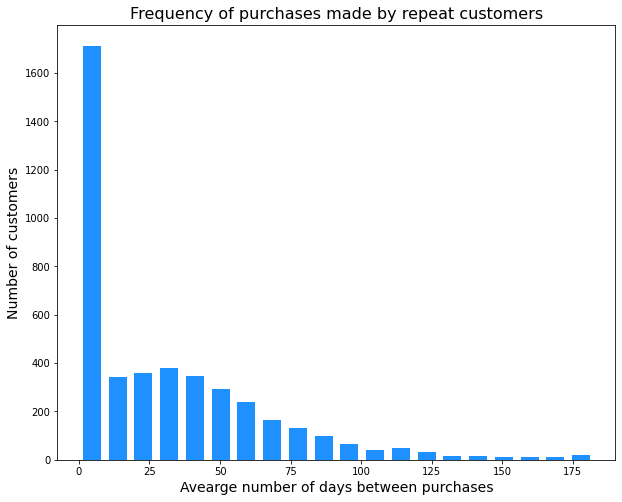

In [28]:
ax = df_summary.InvoiceDate.purchase_frequency.hist(
        bins=20,
        color='dodgerblue',
        rwidth=0.7,
        figsize=(10,8),
        grid=False)
plt.xlabel('Avearge number of days between purchases', fontsize=14)
plt.ylabel('Number of customers', fontsize=14)
plt.title('Frequency of purchases made by repeat customers', fontsize=16);



how to handle this outlier?

In [31]:
df_summary.describe()

sale_value                                                           \
                min            max            sum           avg        count   
count   4339.000000    4339.000000    4339.000000   4339.000000  4339.000000   
mean     263.207606     655.817242    2053.793018    419.047702     4.271952   
std     1215.038798    3088.948020    8988.248381   1796.320814     7.705493   
min        0.000000       0.000000       0.000000      0.000000     1.000000   
25%       92.375000     223.360000     307.245000    178.505000     1.000000   
50%      169.470000     368.310000     674.450000    293.690000     2.000000   
75%      308.630000     621.190000    1661.640000    430.022500     5.000000   
max    77183.600000  168469.600000  280206.020000  84236.250000   210.000000   

            InvoiceDate                     
      purchase_duration purchase_frequency  
count       4339.000000        4339.000000  
mean         130.418530          30.422026  
std          132.039186          34.915188  
min            0.000000           0.000000  
25%            0.000000           0.000000  
50%           92.000000          21.500000  
75%          251.500000          49.000000  
max          373.000000         182.500000

In [50]:
clv_freq = '3M'
df_data = df_orders.reset_index().groupby(['CustomerID',pd.Grouper(key='InvoiceDate',freq=clv_freq)])\
.agg({'sale_value':[sum,groupby_mean, groupby_count]})

In [51]:
df_data = df_data.sale_value.reset_index()

In [52]:
df_data.columns

Index(['CustomerID', 'InvoiceDate', 'sum', 'avg', 'count'], dtype='object')

In [59]:
map_date_month = {str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
                    sorted(df_data.reset_index()['InvoiceDate'].unique(), reverse=True))}

In [60]:
map_date_month

{'2011-12-31': 'M_1',
 '2011-09-30': 'M_2',
 '2011-06-30': 'M_3',
 '2011-03-31': 'M_4',
 '2010-12-31': 'M_5'}

In [61]:
df_data.reset_index()['InvoiceDate'].unique()

array(['2011-03-31T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-06-30T00:00:00.000000000', '2011-09-30T00:00:00.000000000',
       '2011-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [62]:
df_data['M'] = df_data['InvoiceDate'].apply(lambda x: map_date_month[str(x)[:10]])

In [63]:
df_data

,CustomerID,InvoiceDate,sum,avg,count,M
0,12346.0,2011-03-31,77183.60,77183.600000,1,M_4
1,12347.0,2010-12-31,711.79,711.790000,1,M_5
2,12347.0,2011-03-31,475.39,475.390000,1,M_4
3,12347.0,2011-06-30,1018.77,509.385000,2,M_3
4,12347.0,2011-09-30,584.91,584.910000,1,M_2
...,...,...,...,...,...,...
9369,18283.0,2011-06-30,524.68,131.170000,4,M_3
9370,18283.0,2011-09-30,278.09,92.696667,3,M_2
9371,18283.0,2011-12-31,974.21,162.368333,6,M_1
9372,18287.0,2011-06-30,765.28,765.280000,1,M_3


In [64]:
df_features = pd.pivot_table(
                df_data.loc[df_data['M'] != 'M_1'], 
                values=['sum', 'avg', 'count'], 
                columns='M', 
                index='CustomerID')

In [65]:
df_features

avg                                count                 \
M                  M_2      M_3           M_4     M_5   M_2  M_3  M_4  M_5   
CustomerID                                                                   
12346.0            NaN      NaN  77183.600000     NaN   NaN  NaN  1.0  NaN   
12347.0     584.910000  509.385    475.390000  711.79   1.0  2.0  1.0  1.0   
12348.0     310.000000  367.000    227.440000  892.80   1.0  1.0  1.0  1.0   
12350.0            NaN      NaN    334.400000     NaN   NaN  NaN  1.0  NaN   
12352.0     316.250000      NaN    312.362000     NaN   2.0  NaN  5.0  NaN   
...                ...      ...           ...     ...   ...  ...  ...  ...   
18280.0            NaN      NaN    180.600000     NaN   NaN  NaN  1.0  NaN   
18281.0            NaN   80.820           NaN     NaN   NaN  1.0  NaN  NaN   
18282.0     100.210000      NaN           NaN     NaN   1.0  NaN  NaN  NaN   
18283.0      92.696667  131.170    105.966667     NaN   3.0  4.0  3.0  NaN   
18287.0            NaN  765.280           NaN     NaN   NaN  1.0  NaN  NaN   

               sum                             
M              M_2      M_3       M_4     M_5  
CustomerID                                     
12346.0        NaN      NaN  77183.60     NaN  
12347.0     584.91  1018.77    475.39  711.79  
12348.0     310.00   367.00    227.44  892.80  
12350.0        NaN      NaN    334.40     NaN  
12352.0     632.50      NaN   1561.81     NaN  
...            ...      ...       ...     ...  
18280.0        NaN      NaN    180.60     NaN  
18281.0        NaN    80.82       NaN     NaN  
18282.0     100.21      NaN       NaN     NaN  
18283.0     278.09   524.68    317.90     NaN  
18287.0        NaN   765.28       NaN     NaN  

[3616 rows x 12 columns]

In [68]:
df_features.reset_index()
df_features.columns = ['_'.join(col) for col in df_features.columns]

In [69]:
df_features

,avg_M_2,avg_M_3,avg_M_4,avg_M_5,count_M_2,count_M_3,count_M_4,count_M_5,sum_M_2,sum_M_3,sum_M_4,sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,NaN,NaN,77183.600000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,77183.60,NaN
12347.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.000000,367.000,227.440000,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,NaN,NaN,334.400000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,334.40,NaN
12352.0,316.250000,NaN,312.362000,NaN,2.0,NaN,5.0,NaN,632.50,NaN,1561.81,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,NaN,NaN,180.600000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,180.60,NaN
18281.0,NaN,80.820,NaN,NaN,NaN,1.0,NaN,NaN,NaN,80.82,NaN,NaN
18282.0,100.210000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,100.21,NaN,NaN,NaN


In [72]:
df_features.reset_index(level=0, inplace=True)
df_features.fillna(0, inplace=True)

In [73]:
df_features

,index,CustomerID,avg_M_2,avg_M_3,avg_M_4,avg_M_5,count_M_2,count_M_3,count_M_4,count_M_5,sum_M_2,sum_M_3,sum_M_4,sum_M_5
0,0,12346.0,0.000000,0.000,77183.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00
1,1,12347.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
2,2,12348.0,310.000000,367.000,227.440000,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
3,3,12350.0,0.000000,0.000,334.400000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00
4,4,12352.0,316.250000,0.000,312.362000,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3611,3611,18280.0,0.000000,0.000,180.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,180.60,0.00
3612,3612,18281.0,0.000000,80.820,0.000000,0.00,0.0,1.0,0.0,0.0,0.00,80.82,0.00,0.00
3613,3613,18282.0,100.210000,0.000,0.000000,0.00,1.0,0.0,0.0,0.0,100.21,0.00,0.00,0.00
3614,3614,18283.0,92.696667,131.170,105.966667,0.00,3.0,4.0,3.0,0.0,278.09,524.68,317.90,0.00


In [75]:
# Create a column with target
df_target = df_data.loc[df_data['M'] == 'M_1', ['CustomerID', 'sum']]
df_target.columns = ['CustomerID', 'CLV_'+clv_freq]

In [76]:
df_target

,CustomerID,CLV_3M
5,12347.0,1519.14
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67
...,...,...
9361,18276.0,335.86
9362,18277.0,110.38
9367,18282.0,77.84
9371,18283.0,974.21


In [78]:
# All dataset
df_sample_set = df_features.merge(
                df_target, 
                left_on='CustomerID', 
                right_on='CustomerID',
                how='left')
df_sample_set.fillna(0, inplace=True)

In [79]:
df_features.head()

,index,CustomerID,avg_M_2,avg_M_3,avg_M_4,avg_M_5,count_M_2,count_M_3,count_M_4,count_M_5,sum_M_2,sum_M_3,sum_M_4,sum_M_5
0,0,12346.0,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00
1,1,12347.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
2,2,12348.0,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
3,3,12350.0,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00
4,4,12352.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00


In [80]:
df_target.head()

,CustomerID,CLV_3M
5,12347.0,1519.14
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67


In [81]:
df_sample_set.head()

,index,CustomerID,avg_M_2,avg_M_3,avg_M_4,avg_M_5,count_M_2,count_M_3,count_M_4,count_M_5,sum_M_2,sum_M_3,sum_M_4,sum_M_5,CLV_3M
0,0,12346.0,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,0.00
1,1,12347.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,1519.14
2,2,12348.0,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,0.00
3,3,12350.0,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,0.00
4,4,12352.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,311.73


Building Linear Regression
Using the prepared dataset with created features, let us build a linear regression model.

In [82]:
# Import necessary packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, median_absolute_error

In [91]:
target_var = 'CLV_3M'
all_features = [x for x in df_sample_set.columns if x not in ['CustomerID', target_var]]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
                                    df_sample_set[all_features], 
                                    df_sample_set[target_var], 
                                    random_state=2,
                                    test_size=0.35)

# Fit linear regression
lin_reg = LinearRegression(n_jobs=1)
lin_reg.fit(X_train, y_train)

LinearRegression(n_jobs=1)

In [92]:
# Get coefficients for features
coef = pd.DataFrame(list(zip(all_features, lin_reg.coef_)))
coef.columns = ['feature', 'coef']

In [109]:
train_preds =  lin_reg.predict(X_train)
test_preds = lin_reg.predict(X_test)


In [94]:
print('R-Squared for train set: %0.2f',r2_score(y_true=y_train,y_pred=train_preds))
print('R-Squared for test set: %0.2f',r2_score(y_true=y_test,y_pred=test_preds))

R-Squared for train set: %0.2f 0.280288990143181
R-Squared for test set: %0.2f 0.7293666987544117


In [95]:
print('R-Squared for train set: %0.2f',median_absolute_error(y_true=y_train,y_pred=train_preds))
print('R-Squared for test set: %0.2f',median_absolute_error(y_true=y_test,y_pred=test_preds))

R-Squared for train set: %0.2f 254.88949865011477
R-Squared for test set: %0.2f 264.0517707907099


<h4>Scatter plot</h4>

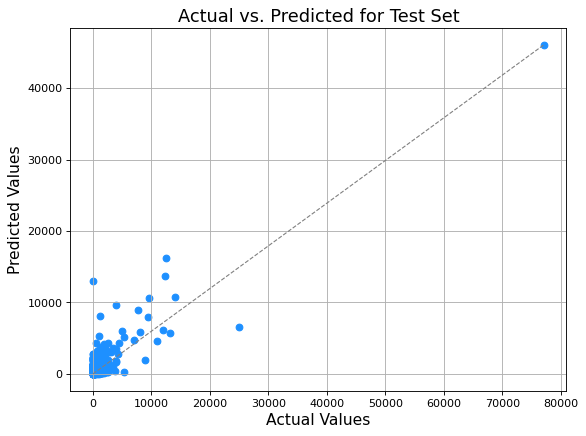

In [100]:
plt.figure(figsize=(8,6),dpi=80)
plt.scatter(y_test,test_preds,color='dodgerblue')
plt.plot([0, max(y_test)], [0, max(test_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual vs. Predicted for Test Set', fontsize=16)
plt.grid()

<h4>Summary</h4>
<ul>
    <li>Based on the data analysis, we found that the repeat customers tend to make about 12 purchases or less 
    within a year and the majority of repeat customers tend to make a purchase every 12 to 50 days</li>
    <li>We predicted 3-month CLTV for customers of online retail using linear regression</li>
    <li>R-squared value for the test set is 0.71, which is not great but it is a good benchmark to try other regression models
        such as Epsilon-Support Vector Regression and Random Forest Regressor </li>
    <li>By knowing CLTV, we can develop positive ROI strategies and make decisions about how much money to invest
    in acquiring new customers and retaining existing ones.</li>
</ul>